# Population Splitting for IBD Exomes v36 - 09/05/19
## Author: Guhan Venkataraman

The below cell takes care of the necessary imports.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import os

The next cell reads in the files containing the lists of Thousand Genomes and CCDG Genomes samples.

In [2]:
with open('../sample_lists/1kg_samples.tsv') as f:
    kg_samples = f.readlines()
kg_samples = [x.strip() for x in kg_samples]

with open('../sample_lists/ccdg_samples.tsv') as f:
    ccdg_samples = f.readlines()
ccdg_samples = [x.strip() for x in ccdg_samples]

Now, we read in the PC projections of 1kG loadings onto all samples (generated via `pca.py` and the Hail package, in this same directory), parsing the raw file (which is messily formatted) into a human readable format and writing to file.

In [3]:
All = pd.read_table('1kg_pca_projections_all_samples.tsv')
All['scores'] = All['scores'].str.replace('[', '').str.replace(']', '')
cols = ['PC'+ str(i) for i in range(10)]
All[cols] = All['scores'].str.split(',', expand=True).astype(np.float64)
cols = ['s'] + cols
All = All[cols]
All.to_csv('1kg_pca_projections_all_samples_clean.tsv', sep='\t', index=False)

In order to visualize the projections by dataset, we create a "dataset" column via the sample manifests we loaded up previously.

v36 samples: 55705
CCDG samples: 7919
1kG samples: 3212


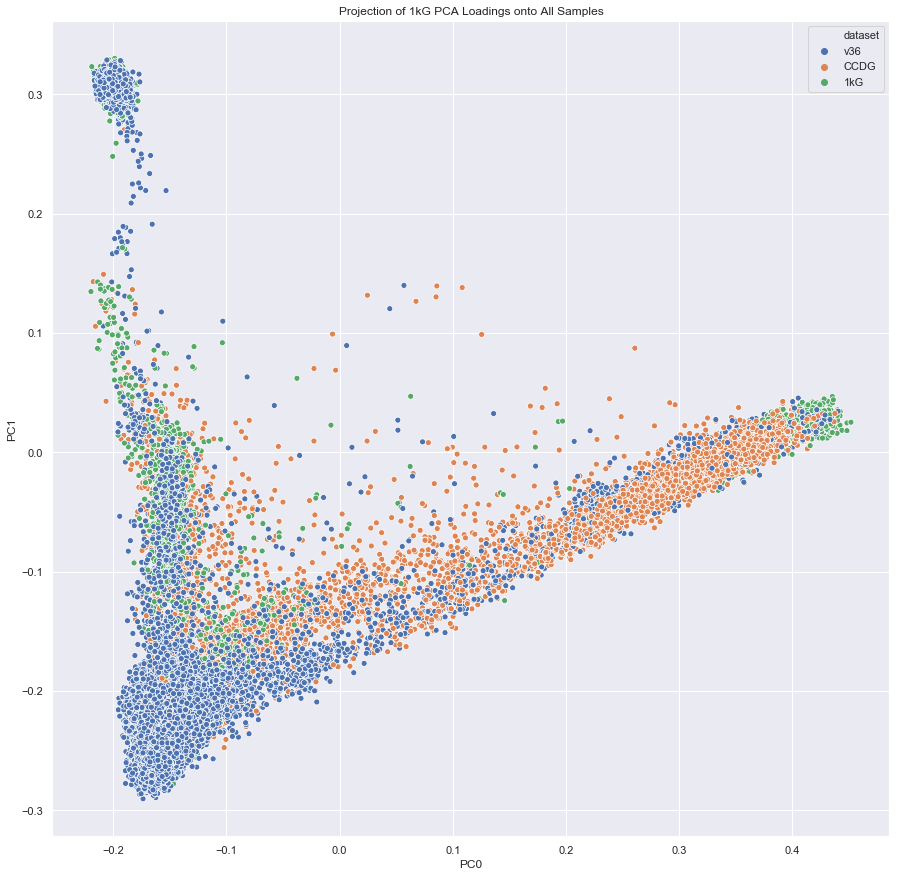

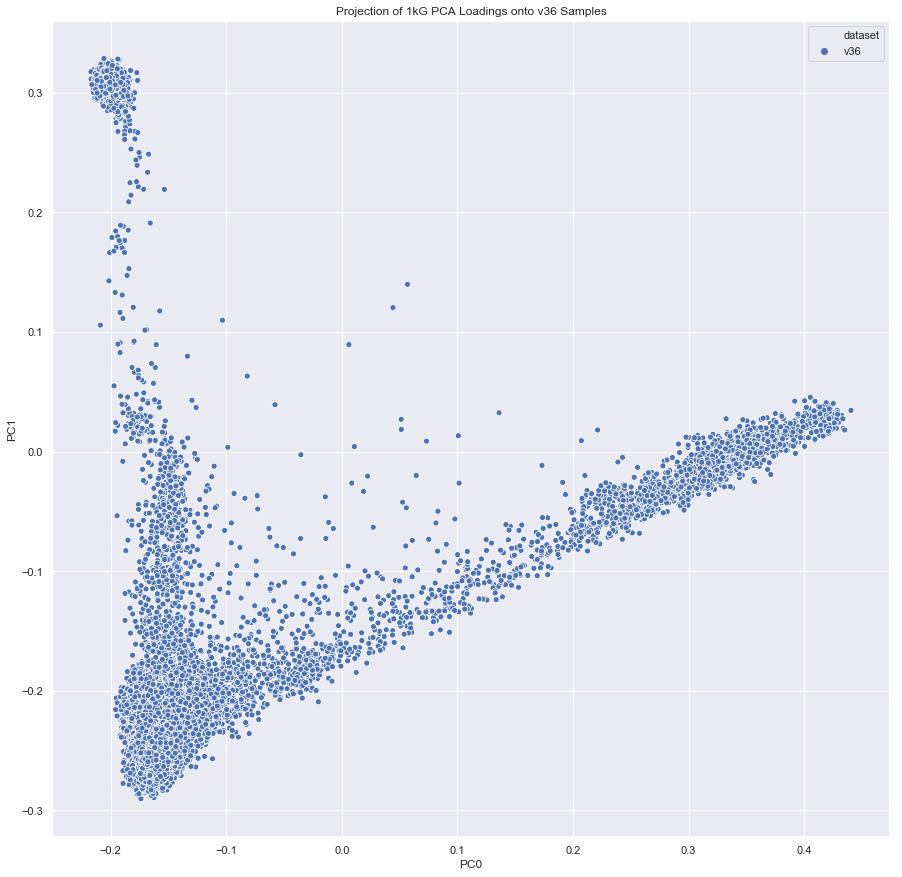

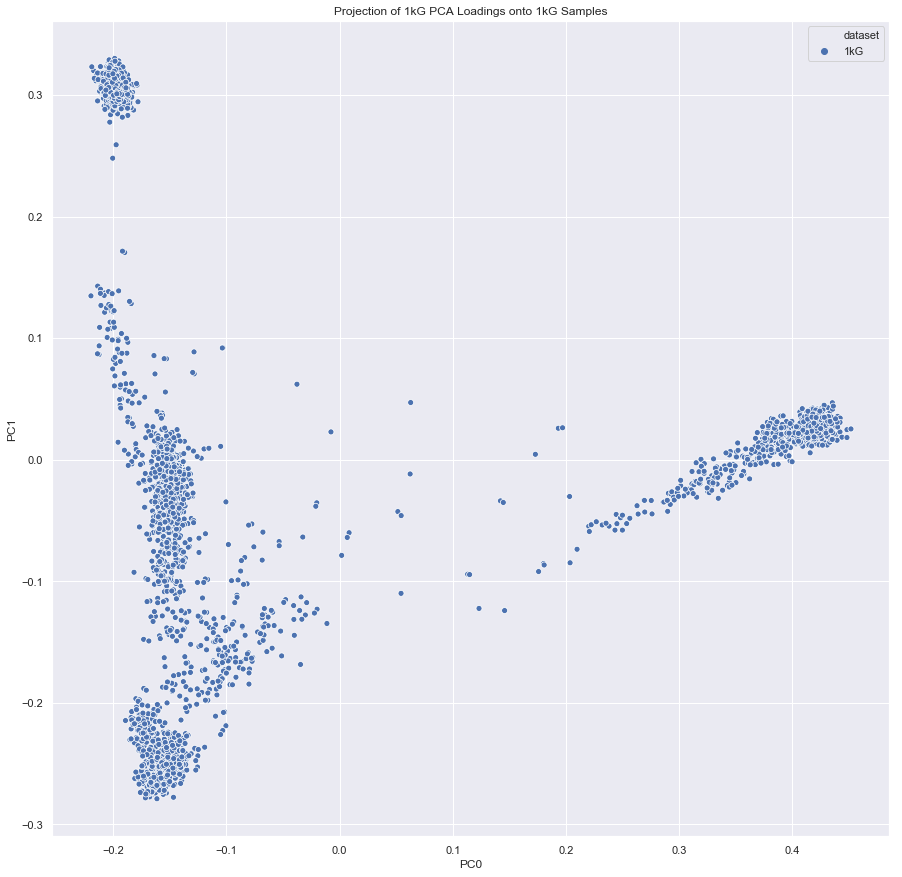

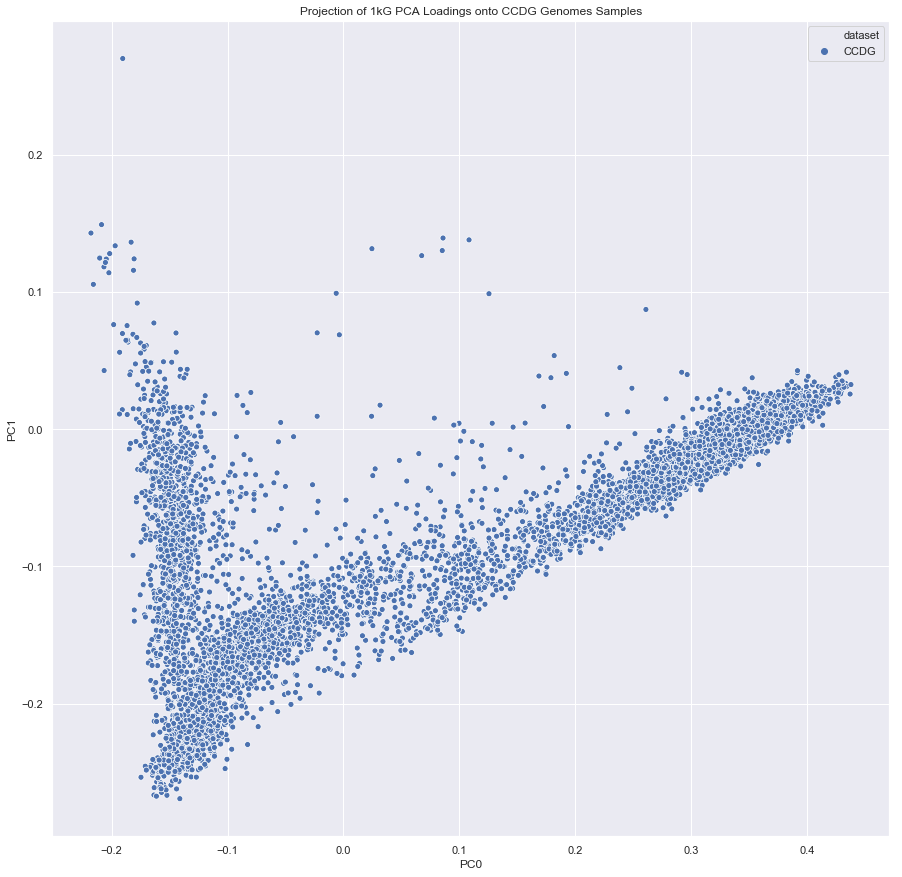

In [4]:
All['dataset'] = 'NA'
for i, row in All.iterrows():
    if (All.at[i, 's'] in kg_samples):
        All.at[i, 'dataset'] = '1kG'
    elif (All.at[i, 's'] in ccdg_samples):
        All.at[i, 'dataset'] = 'CCDG'
    else:
        All.at[i, 'dataset'] = 'v36'
CCDG = All[All['dataset'] == 'CCDG']
KG = All[All['dataset'] == '1kG']
v36 = All[All['dataset'] == 'v36']
print("v36 samples: " + str(len(v36)))
print("CCDG samples: " + str(len(CCDG)))
print("1kG samples: " + str(len(KG)))
# Graphs of each dataset, combined and separate
for dataset, name in zip([All, v36, KG, CCDG], ['All', 'v36', '1kG', 'CCDG Genomes']):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot('PC0', 'PC1', hue='dataset', label='', data=dataset).set_title('Projection of 1kG PCA Loadings onto ' + name + ' Samples')

The next step in this process is to do an iterative RF classification on the samples that do not yet have population labels.

The first RF is trained on 1kG data and labels - African-American (AFR), "American"/Hispanic/Native American (AMR), European (EUR), East Asian (EAS), and South Asian (SAS) - collectively referred to as "superpopulation labels". The RF predicts the superpopulation label of every sample in the dataset.

The second RF is trained to re-classify those classified as EUR in the previous step as members of Ashkenazi Jew (AJ), French Canadian (FC), Finnish (FIN), Lithuanian (LIT), or Non-Finnish European (NFE) populations. Samples already labeled as such are the training data, and those EUR samples that don't yet have a sub-population classification will utilize predictions from this classifier.

In the end, we will always use the most accurate label possible. That is, if an AFR sample from the CCDG Genomes is explicitly already classified as such, regardless of whether or not the first or second RFs misclassify the sample, we will use the correct label.

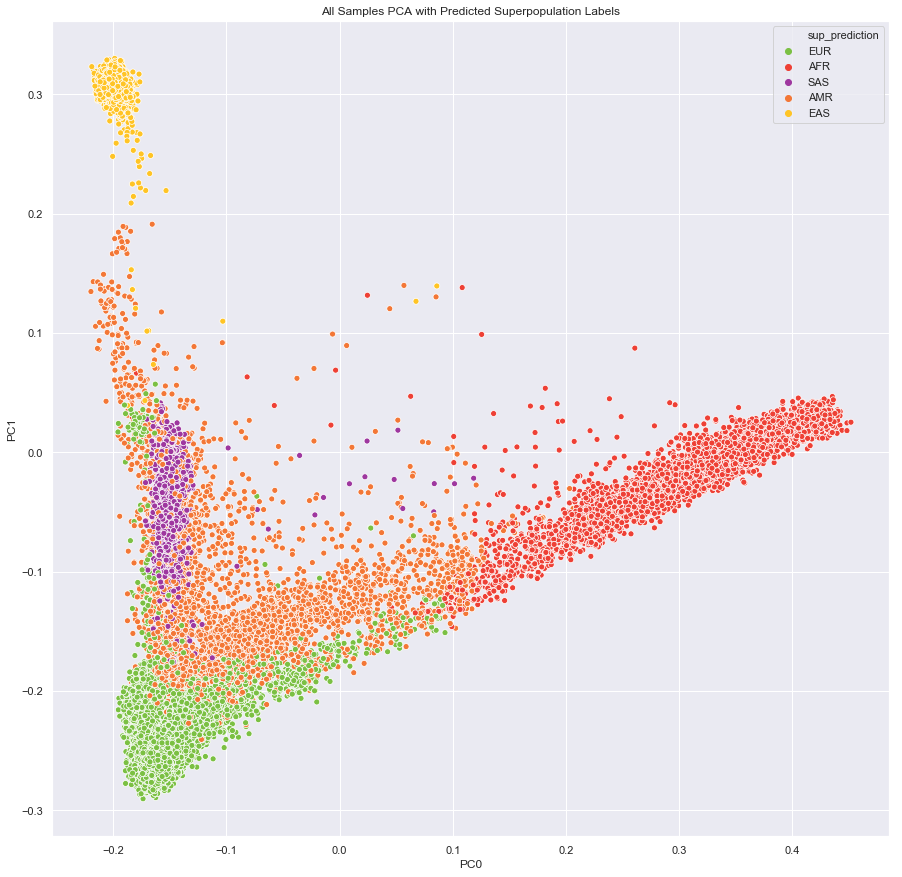

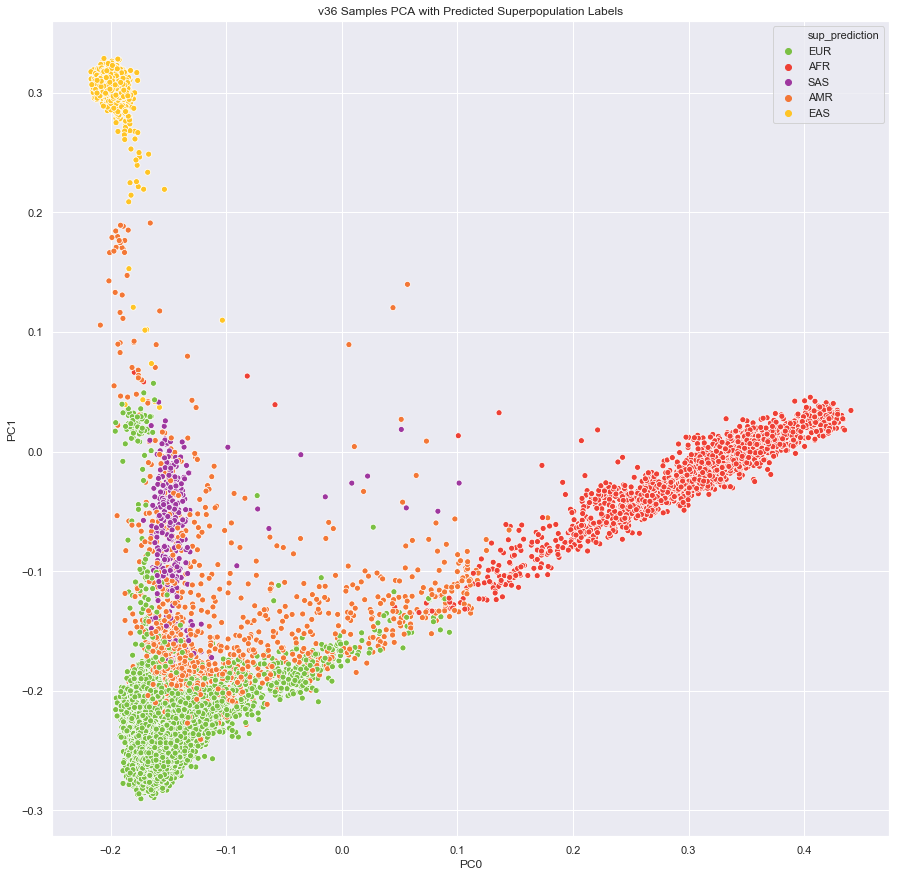

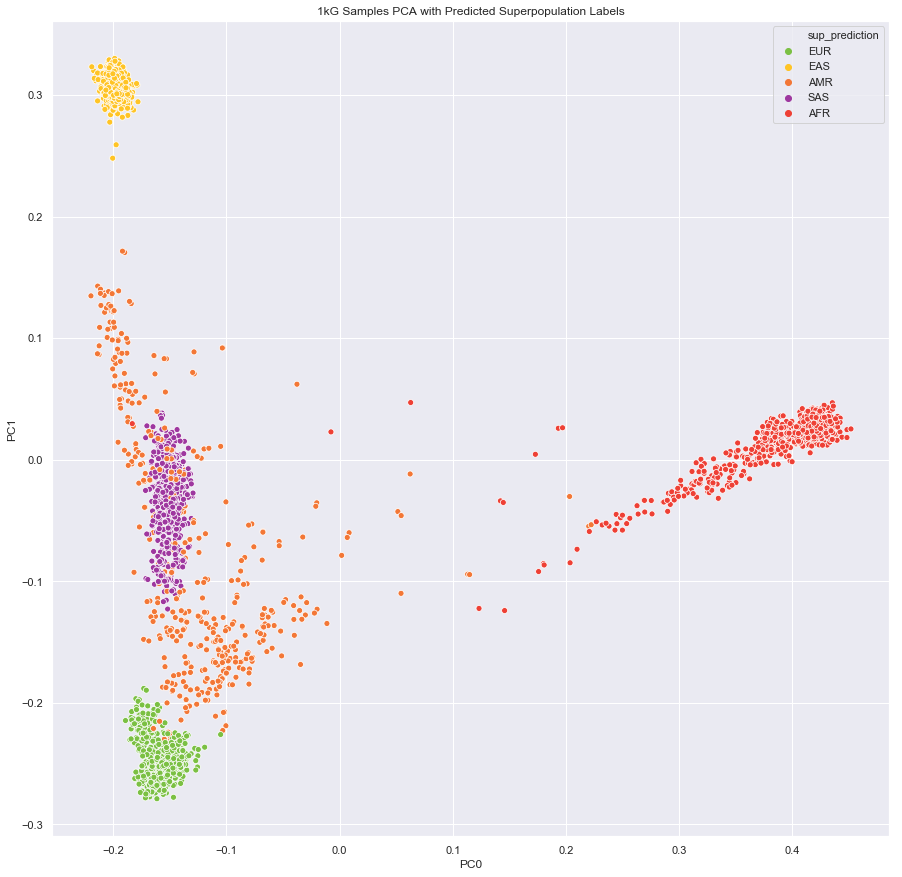

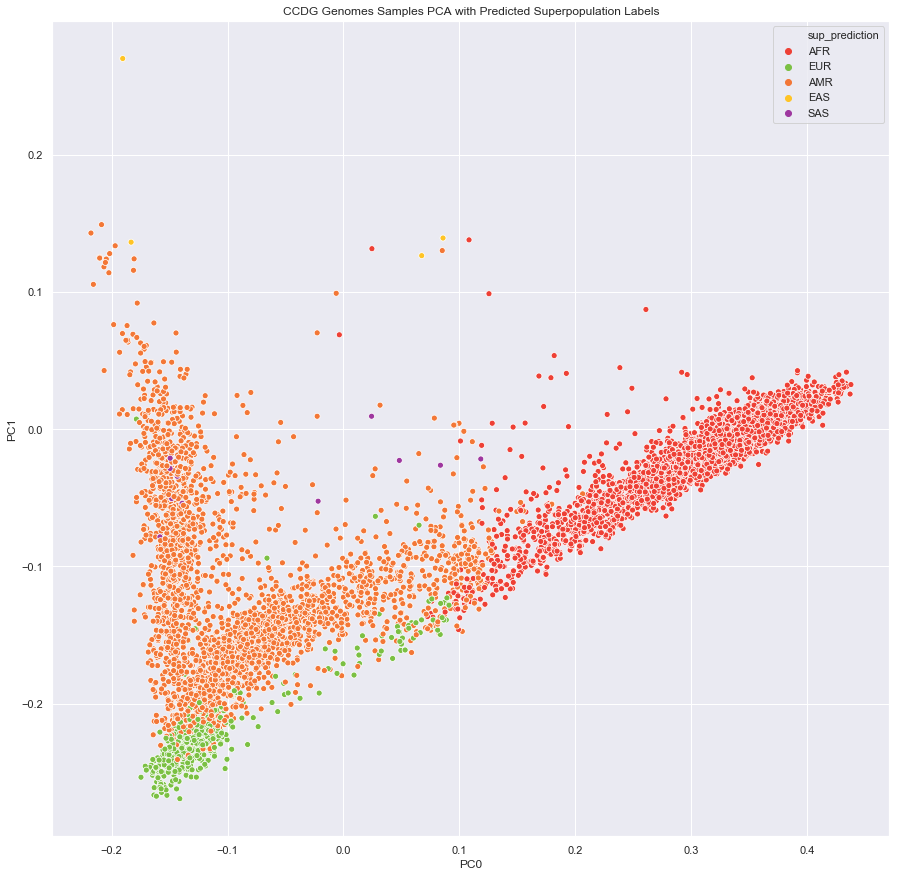

In [5]:
# Gathering train data
pc_data = pd.read_table('1kg_pca_projections_all_samples_clean.tsv').drop_duplicates()
kg = pd.read_table('1kgpop.tsv')
#Filter for those samples in our dataset
kg = kg.merge(pc_data, left_on='Sample name', right_on='s')

# Initializing and fitting the classifier
sup_rfc = RandomForestClassifier()
X_train = kg.columns[3:]
y_train = kg.columns[1]
sup_rfc.fit(kg[X_train], kg[y_train])
sup_pops = ['AFR', 'AMR', 'EAS', 'EUR', 'SAS']
pc_data['sup_prediction'] = sup_rfc.predict(pc_data[X_train])
for i, row in pc_data.iterrows():
    if (pc_data.at[i, 's'] in kg_samples):
        pc_data.at[i, 'dataset'] = '1kG'
    elif (pc_data.at[i, 's'] in ccdg_samples):
        pc_data.at[i, 'dataset'] = 'CCDG'
    else:
        pc_data.at[i, 'dataset'] = 'v36'
CCDG = pc_data[pc_data['dataset'] == 'CCDG']
KG = pc_data[pc_data['dataset'] == '1kG']
v36 = pc_data[pc_data['dataset'] == 'v36']

# Graphs of each dataset, combined and separate, with predicted superpopulation as hue
for dataset, name in zip([pc_data, v36, KG, CCDG], ['All', 'v36', '1kG', 'CCDG Genomes']):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot('PC0', 'PC1', hue='sup_prediction', data=dataset, palette=dict(AFR="#ee4035", AMR="#f37736", EAS="#ffc425", EUR="#7bc043", NA="#0392cf", SAS="#9e379f")).set_title(name + ' Samples PCA with Predicted Superpopulation Labels')

Now that we have superpopulation codes for each sample, the next step in the procedure is to retrieve sample-level sub-population annotations and diagnoses. We merge these data with our existing principal component data.

In [6]:
# Read in table with sub-populations and diagnoses
pops = pd.read_table('v36+ccdg_pop+diagnosis.tsv').drop_duplicates()
pops = pops.replace('AFRICAN AMERICAN', 'AFR')

pc_data = pc_data.merge(pops, left_on=['s'], right_on='SAMPLE_ID').drop('SAMPLE_ID',axis=1)
#NO POPULATION MAPPING for these
pc_data = pc_data[~(pc_data['COHORT'].isin(['ALM', 'NEC', 'FARMER']))]

It is important to note that the Random Forest classifier is just that - there is a certain degree of randomness to superpopulation label assignment for those non-obvious fringe cases. Thus, we have frozen the list of train and test samples below.

In [7]:
# For generating list of test and train samples
eur_pops = ['AJ', 'FC', 'FIN', 'NFE', 'LIT']
unfinalized_pops = ['CONTROL', 'US- NIDDK', 'US- Other Cohorts', 'US- MGH PRISM']
if not os.path.exists('pc_data_090519.tsv'):
    print("Writing...")
    pc_data.to_csv('pc_data_090519.tsv', sep='\t', index=False)

In [8]:
pc_data = pd.read_table('pc_data_090519.tsv')
eur_train_data = list(pc_data[pc_data['RACE/ETHNICITY'].isin(eur_pops)]['s'])
eur_test_data = list(pc_data[(pc_data['sup_prediction'] == 'EUR') & (pc_data['RACE/ETHNICITY'].isin(unfinalized_pops))]['s'])
eur_samples_to_pca = set(eur_train_data).union(set(eur_test_data))
if not os.path.exists('eur_samples_to_pca.tsv'):
    with open('eur_samples_to_pca.tsv', 'w') as f:
        print("Writing...")
        f.write("s\n")
        for item in list(eur_samples_to_pca):
            f.write("%s\n" % item)

Now that we have a freeze of train and test samples for the European classifier, the next step is to run PCA on these samples (`eur_pca.py`). This should generate a file called `eur_pca_scores.tsv.bgz` in the Google Cloud bucket, that can be copied over, renamed as `eur_pca_scores.tsv.gz`, and `gunzip`ed. We clean the file in the following cell.

In [9]:
eur_pc_data = pd.read_table('eur_pca_scores.tsv')
eur_pc_data['scores'] = eur_pc_data['scores'].str.replace('[', '').str.replace(']', '')
eur_cols = ['EUR_PC'+ str(i) for i in range(10)]
eur_pc_data[eur_cols] = eur_pc_data['scores'].str.split(',', expand=True).astype(np.float64)
eur_cols = ['s'] + eur_cols
eur_pc_data = eur_pc_data[eur_cols]
eur_pc_data.to_csv('eur_pca_scores_clean.tsv', sep='\t', index=False)

There are some 1kG and other samples that are duplicated across our datasets. We get rid of these samples below.

In [10]:
eur_pc_data = eur_pc_data.merge(pops, left_on=['s'], right_on='SAMPLE_ID').drop('SAMPLE_ID',axis=1)
#Check for duplicate ids - if so, remove from set
duplicate_entries = pc_data.groupby('s').size().reset_index().rename(columns={0:'records'})
duplicates = list(duplicate_entries[duplicate_entries['records'] != 1 ]['s'])
problematic_samples = list(np.unique(pc_data[pc_data['s'].isin(duplicates) & ~(pc_data['s'].isin(kg_samples))]['s']))
pc_data = pc_data[~pc_data['s'].isin(problematic_samples)]
eur_pc_data = eur_pc_data[~eur_pc_data['s'].isin(problematic_samples)]

Below is the logic that assigns the final label (`sub_prediction`) as the best possible label for those samples that are already classified.

In [11]:
finalized_pops = ['AFR', 'AJ', 'EAS', 'FC', 'FIN', 'HISPANIC', 'NFE', 'PUERTO RICAN', 'LIT']
for i, row in pc_data.iterrows():
    if (pc_data.at[i, 'RACE/ETHNICITY'] in finalized_pops):
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'RACE/ETHNICITY']
    else:  
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'sup_prediction']

We merge the EUR PCs with the original PCs and annotations.

In [12]:
eur_train_pc_data = eur_pc_data[eur_pc_data['s'].isin(eur_train_data)].merge(pc_data)
eur_train_pc_data = eur_train_pc_data[~eur_train_pc_data.duplicated('s')]
eur_test_pc_data = eur_pc_data[eur_pc_data['s'].isin(eur_test_data)].merge(pc_data)
eur_test_pc_data = eur_test_pc_data[~eur_test_pc_data.duplicated('s')]

We now train the second classifier and predict to generate labels for all non-classified EUR samples.

In [13]:
eur_rfc = RandomForestClassifier()
X_train = eur_train_pc_data.columns[1:11]
y_train = eur_train_pc_data.columns[-1:]
eur_rfc.fit(eur_train_pc_data[X_train], eur_train_pc_data[y_train])
eur_test_pc_data['eur_prediction'] = eur_rfc.predict(eur_test_pc_data[X_train])
pc_data = eur_test_pc_data.merge(pc_data, how='outer')
for i, row in pc_data.iterrows():
    if pc_data.at[i, 's'] in eur_test_data:
        pc_data.at[i, 'sub_prediction'] = pc_data.at[i, 'eur_prediction']

/Users/guhan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


The predictions can be visualized below.

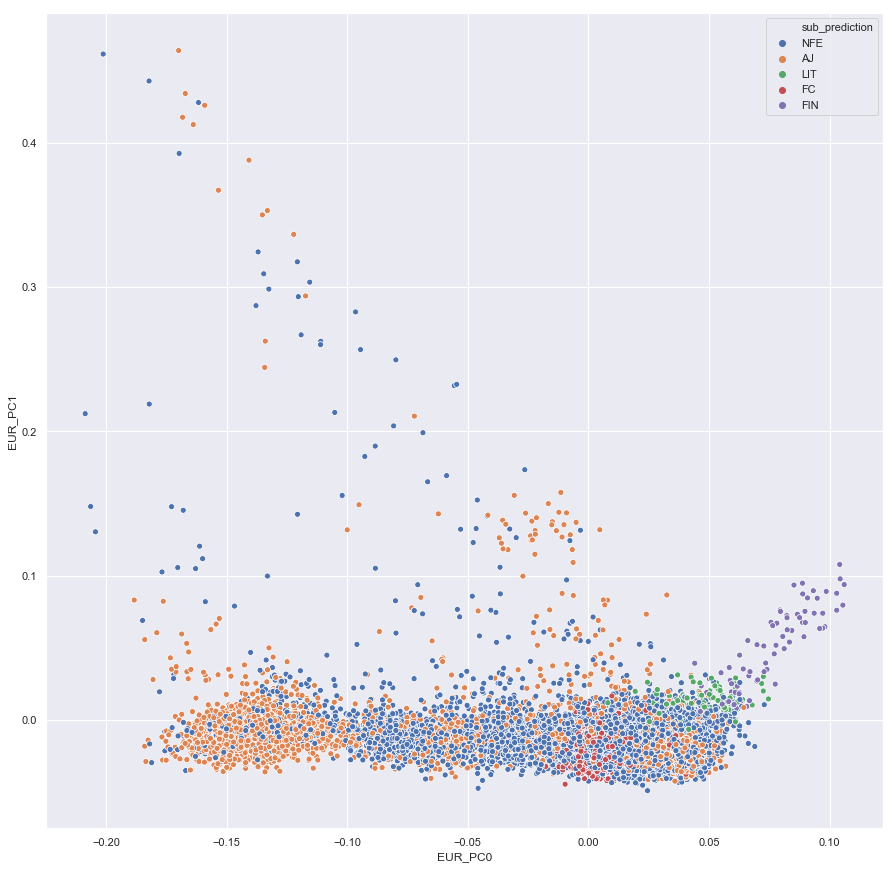

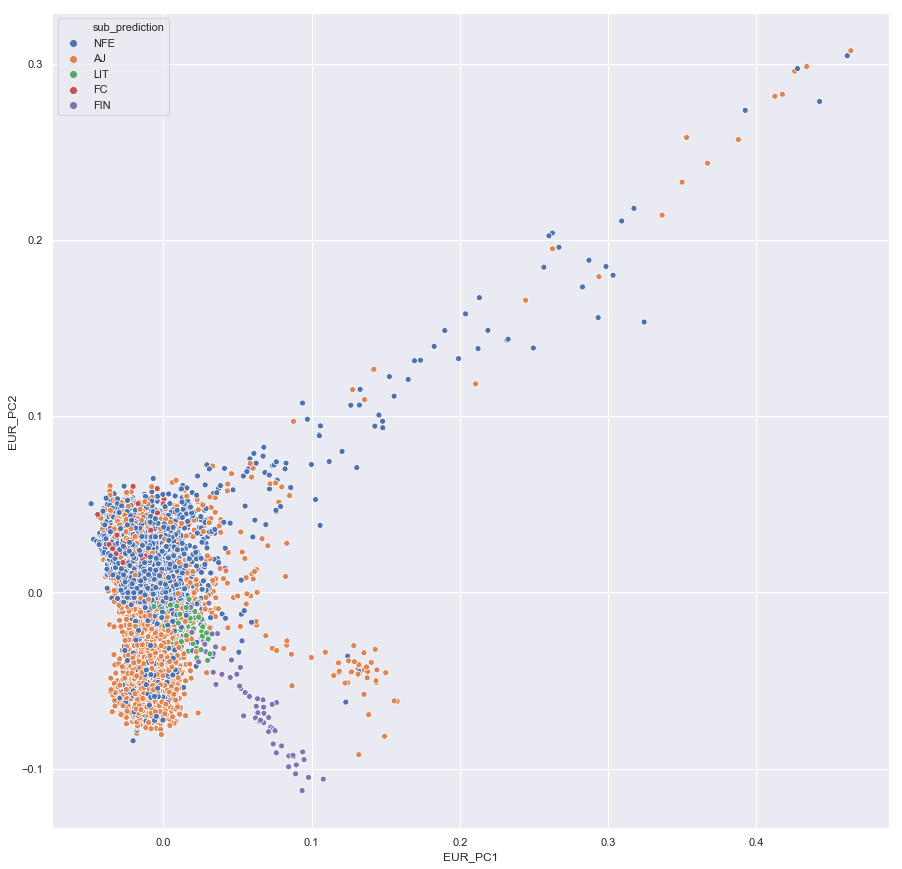

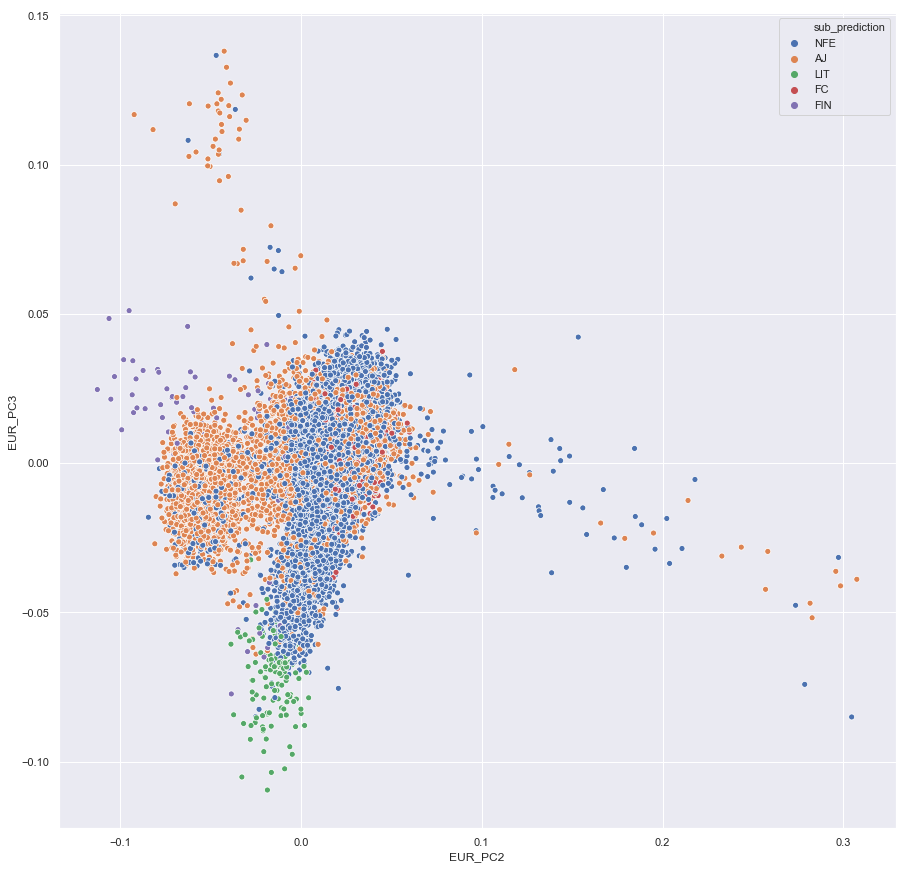

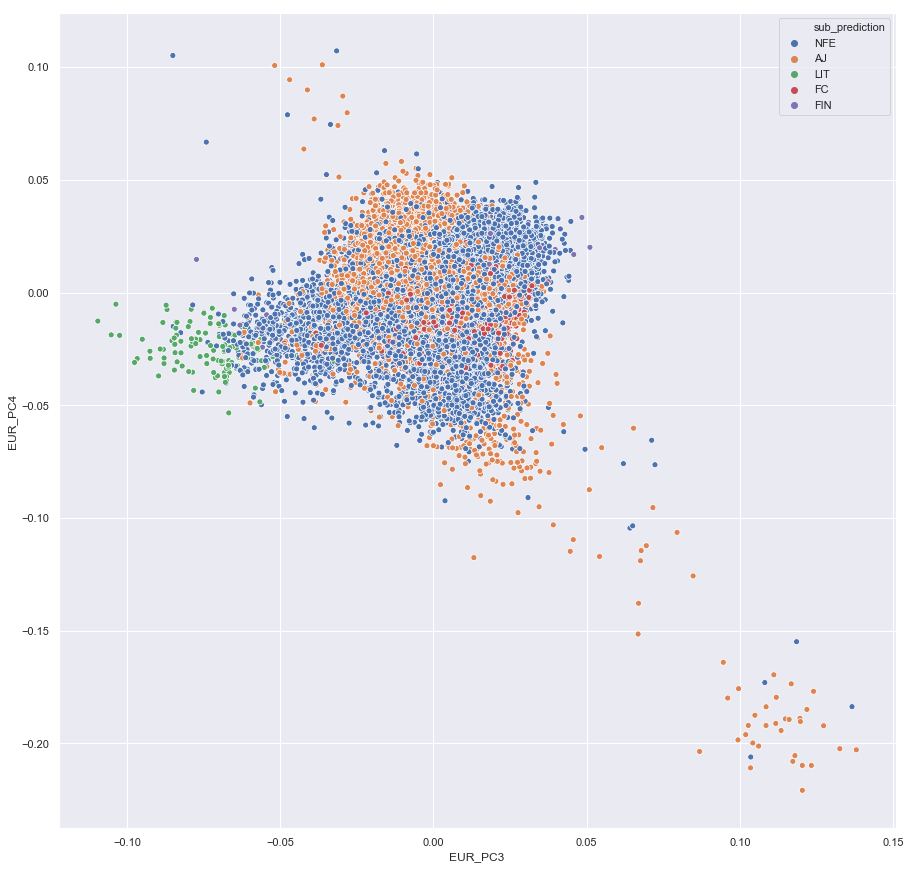

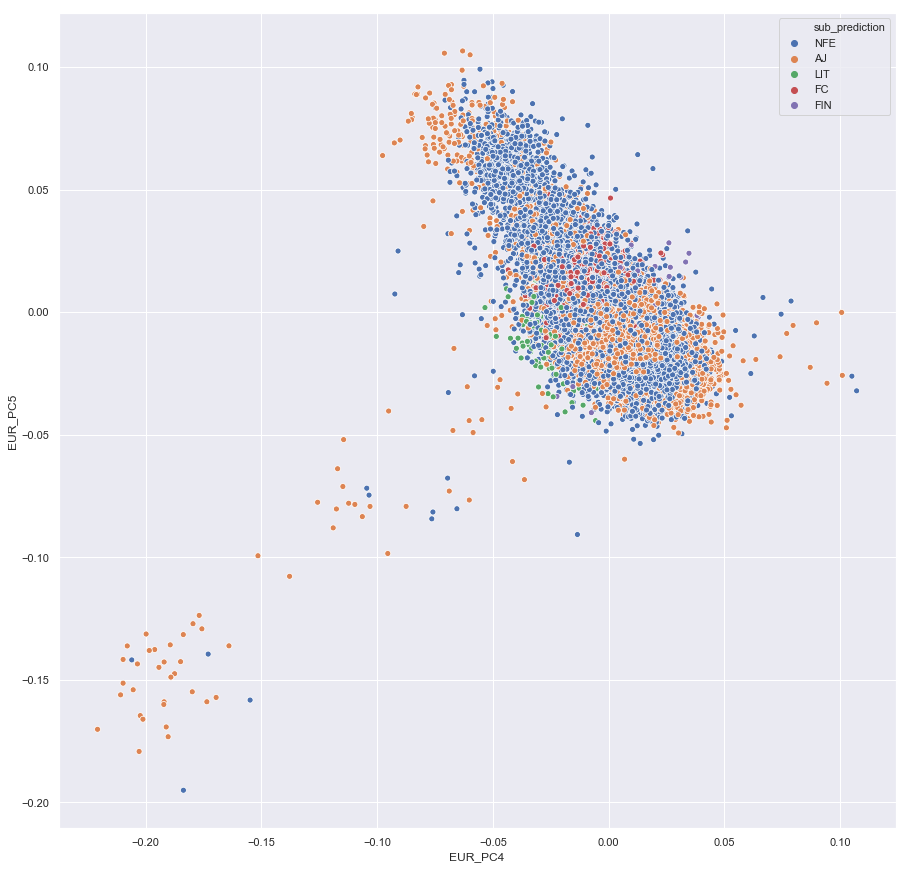

In [14]:
eur_pcs = eur_cols[1:]
for i in range(5):
    plt.figure(figsize=(15,15))
    sns.set()
    sns.scatterplot(eur_pcs[i], eur_pcs[i+1], hue='sub_prediction', data=pc_data[pc_data['s'].isin(list(eur_pc_data['s']))])#, #palette=dict(AFR="#ee4035", AMR="#f37736", EAS="#ffc425", EUR="#7bc043", NA="#0392cf", SAS="#9e379f")).set_title(name + ' Samples PCA with Predicted Superpopulation Labels')

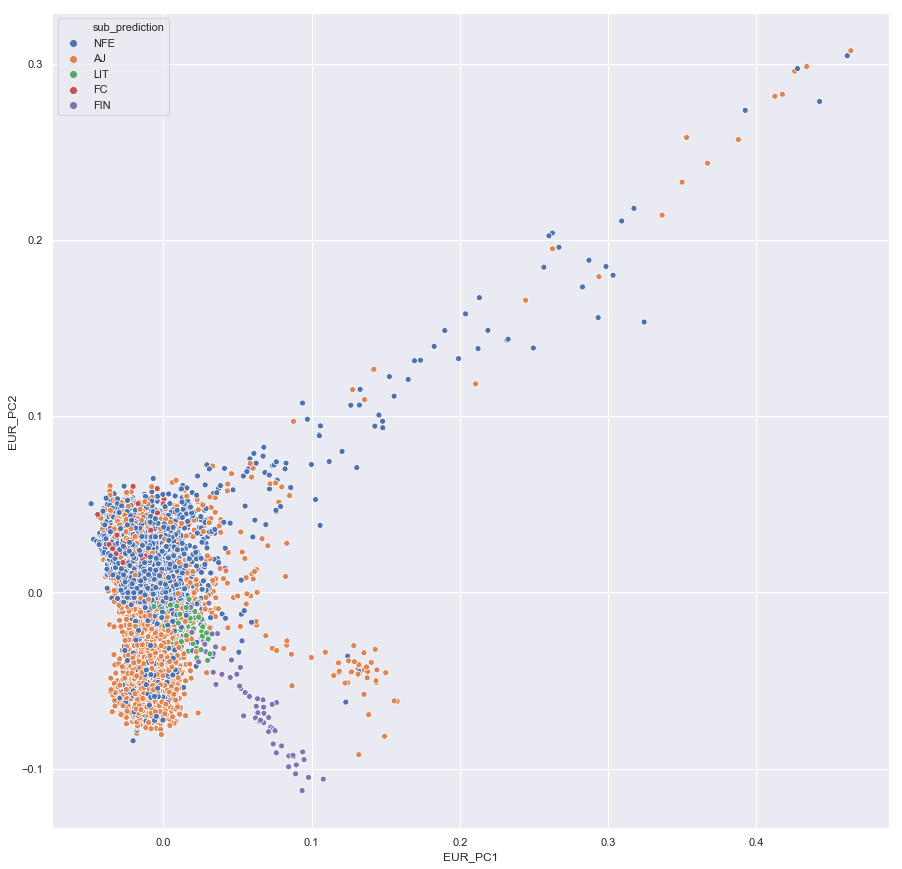

In [15]:
plt.figure(figsize=(15,15))
sns.set()
sns.scatterplot('EUR_PC1', 'EUR_PC2', hue='sub_prediction', data=pc_data[pc_data['s'].isin(list(eur_pc_data['s']))])#, #palette=dict(AFR="#ee4035", AMR="#f37736", EAS="#ffc425", EUR="#7bc043", NA="#0392cf", SAS="#9e379f")).set_title(name + ' Samples PCA with Predicted Superpopulation Labels')

Some samples erroneously were classified as South Asians across our datasets. If not explicitly from 1kG samples that are actually SAS, we assume that these samples were actually AMR samples that were misclassified.

In [16]:
#Replace all SAS with AMR BUT NOT THOSE IN KG
for i, row in pc_data.iterrows():
    if pc_data.at[i, 's'] not in kg_samples and pc_data.at[i, 'sub_prediction'] == 'SAS':
        pc_data.at[i, 'sub_prediction'] = 'AMR'

In [17]:
# Drop unnecessary columns
pc_data = pc_data.drop(['EUR_PC'+ str(i) for i in range(10)] + ['eur_prediction'], axis=1)
if not os.path.exists('pc_data_sub_predictions_090519.tsv'):
    print("Writing...")
    pc_data.to_csv('pc_data_sub_predictions_090519.tsv', sep='\t', index=False)

And there we have it - finalized labels for all samples in our datasets. This was also frozen in the cell above. Enjoy the pretty picture.

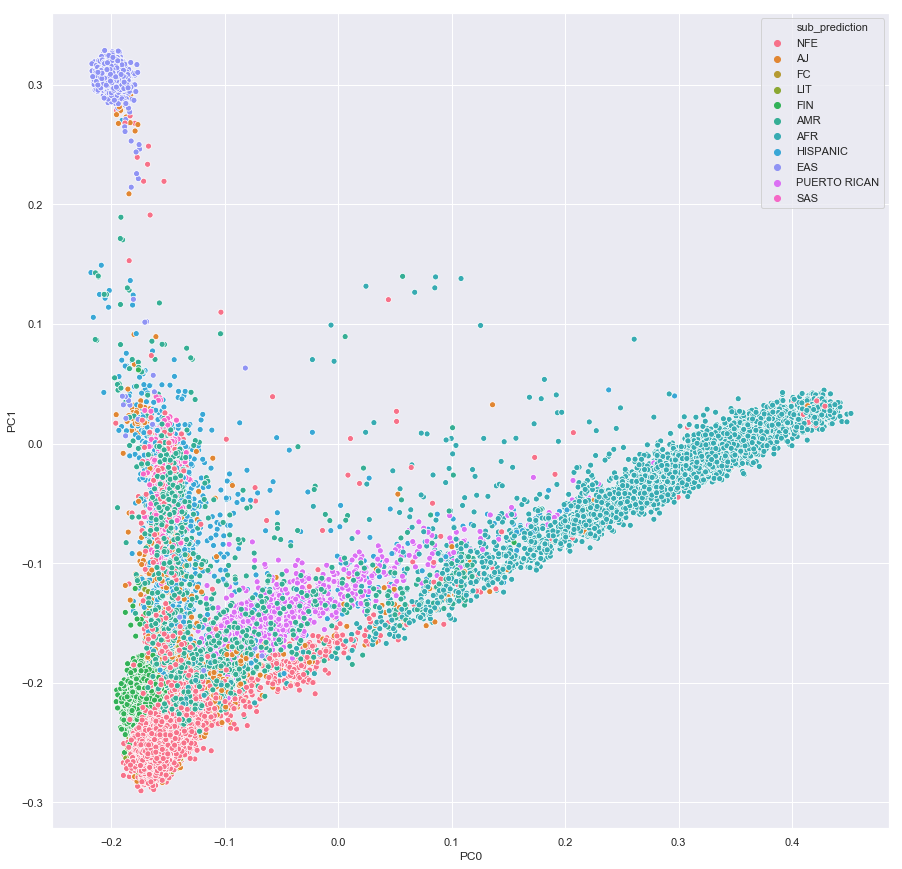

In [18]:
pc_data = pd.read_table('pc_data_sub_predictions_090519.tsv')
plt.figure(figsize=(15,15))
sns.set()
sns.scatterplot('PC0', 'PC1', hue='sub_prediction', data=pc_data)#, #palette=dict(AFR="#ee4035", AMR="#f37736", EAS="#ffc425", EUR="#7bc043", NA="#0392cf", SAS="#9e379f")).set_title(name + ' Samples PCA with Predicted Superpopulation Labels')

The final step is to generate the lists needed to run future analyses - GWAS, local ancestry painting, etc.

- AJ, EAS, FIN, FC, LIT, NFE, SAS  samples are written to file
- AMR, HISPANIC, and PUERTO RICAN samples are combined into one file (HIS) for future local ancestry painting
- AFR are also written to file for future local ancestry painting

In [19]:
for pop in ['AJ', 'EAS', 'FIN', 'FC', 'LIT', 'NFE', 'SAS']:
    df = pc_data[pc_data['sub_prediction'] == pop]
    df[['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/' + pop + '_sample_list.tsv', sep='\t', index=False)

pc_data[pc_data['sub_prediction'].isin(['AMR', 'HISPANIC', 'PUERTO RICAN'])][['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/HIS_sample_list.tsv', sep='\t', index=False)
pc_data[pc_data['sub_prediction'] == 'AFR'][['s', 'COHORT', 'dataset', 'DIAGNOSIS']].to_csv('final_population_lists/AFR_sample_list.tsv', sep='\t', index=False)